In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import sklearn as sk
import joblib
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,cross_validate
import timeit
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
import sys
from sksurv.metrics import concordance_index_ipcw,concordance_index_censored
from sksurv.ensemble import RandomSurvivalForest
from sklearn.preprocessing import StandardScaler
random_state = 108
from pickle import load
from sksurv.nonparametric import kaplan_meier_estimator,SurvivalFunctionEstimator
from sksurv.metrics import (
    as_concordance_index_ipcw_scorer,
    as_cumulative_dynamic_auc_scorer,
    as_integrated_brier_score_scorer,
)
from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA,KernelPCA
from sklearn.manifold import TSNE
from pickle import dump
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest

In [2]:
n_folds = 5
seed = 108

In [3]:
from sksurv.metrics import cumulative_dynamic_auc
def calc_dyn_auc(model,X,y,y_train,time_max=365,time_interval=7):
    
    times = np.arange(1e-5, time_max, time_interval)
    chf_funcs = model.predict_cumulative_hazard_function(X)
    risk_scores = np.row_stack([chf(times) for chf in chf_funcs])
    auc, mean_auc = cumulative_dynamic_auc(y_train, y, risk_scores, times)

    return auc, mean_auc,times

In [4]:
from sksurv.metrics import integrated_brier_score
def calc_ibs(model,X,y,y_train,time_max=365,time_interval=7):
    
    times = np.arange(1e-5, time_max, time_interval)
    surv_prob = np.vstack([fn(times) for fn in model.predict_survival_function(X)])
    ibs = integrated_brier_score(y_train, y, surv_prob, times)

    return ibs

In [5]:
def plot_auc(cph_auc,cph_mean_auc,times):
    plt.plot(times, cph_auc, "o-", label=f"Mean AUC = {cph_mean_auc:0.3f})")
    plt.axhline(cph_mean_auc, linestyle="--",color='r')
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.legend(loc="lower center")
    plt.grid(True)

In [6]:
def plot_cph_coef(cph,feature_names=None):
    coefs = cph.coef_.reshape((-1))
    if feature_names is None:
        feature_names = cph.feature_names_in_
    df = pd.Series(index = feature_names,data=coefs)
    non_zero_coef = df[df > 1e-5].sort_values(ascending=False)
    ax = sns.barplot(x=non_zero_coef.index, y=non_zero_coef.values)
    plt.setp(ax.get_xticklabels(), rotation=45)

In [7]:
def plot_grid_search_results(gcv, ax, name, param = "max_depth"):
    ax.errorbar(
        x=gcv.cv_results_["param_model__estimator__{}".format(param)].filled(),
        y=gcv.cv_results_["mean_test_score"],
        yerr=gcv.cv_results_["std_test_score"],
    )
    ax.plot(
        gcv.best_params_["model__estimator__{}".format(param)],
        gcv.best_score_,
        "ro",
    )
    ax.set_ylabel(name)
    ax.yaxis.grid(True)

In [8]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5):
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=cv)
    
    train_scores_mean = np.nanmean(train_scores, axis=1)
    train_scores_std = np.nanstd(train_scores, axis=1)
    val_scores_mean = np.nanmean(val_scores, axis=1)
    val_scores_std = np.nanstd(val_scores, axis=1)
    
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std,color='r',alpha=0.2)
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.fill_between(train_sizes, val_scores_mean-val_scores_std, val_scores_mean+val_scores_std,color='g',alpha=0.2)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title("Learning Curves")
    plt.show()


In [9]:
train = pd.read_csv("train.csv",index_col = 0)
#X_train = train.query('death_observed == True or death_in_study == False')
outcome_columns = ['death_in_study','upper_bound',
                       'discharge_status_new','fup_status_30d_new', 'fup_status_12mth_new','lower_bound','death_observed',
                  'event_observed', 'event_max','event_min','event_mid']
X_train = train.drop(outcome_columns,axis=1)
X_train = X_train.drop(["egfr_pre"],axis=1)

In [10]:
logrank_test = pd.read_csv('results/logrank_test.csv',index_col=0)
category_variables = logrank_test.query('reject == True')['category']
vif = pd.read_csv('results/vif_test.csv',index_col=0)

unicoxph = pd.read_csv('results/coxph_univariate_test.csv',index_col=0)
uni_var = unicoxph.query('p < 0.05').index
continuous_variables = vif.query('VIF <= 7.0')['feature']

In [11]:
#column_list = list(category_variables) + list(continuous_variables)
column_list = uni_var
#X_train = X_train.loc[:,column_list]

In [12]:
#scaler =  StandardScaler()
#X_train_scale = scaler.fit_transform(X_train)
#X_train_scale = pd.DataFrame(X_train_scale,columns=X_train.columns,index=train.index)

In [13]:

y = train[["event_observed","event_max" ]]

records = y.to_records(index=False)
y_train = np.array(records, dtype = records.dtype.descr)
test = pd.read_csv("test.csv",index_col = 0)

X_test = test.drop(outcome_columns,axis=1)
X_test = X_test.drop(["egfr_pre"],axis=1)
#X_test = X_test.loc[:,column_list]
#X_test_scale = scaler.transform(X_test)
#X_test_scale = pd.DataFrame(X_test_scale,columns=X_test.columns,index=test.index)

y_test = test[["event_observed","event_max" ]]

records = y_test.to_records(index=False)
y_test = np.array(records, dtype = records.dtype.descr)

In [14]:
cph = CoxPHSurvivalAnalysis()
times = np.arange(1e-5, 365, 7)
pipeline = Pipeline(
        [('scaler', StandardScaler()),
         #('dim_reduce', KernelPCA(n_components = 20,kernel='rbf')),
         ('model',  as_cumulative_dynamic_auc_scorer(cph, times=times) )]
    )

In [193]:

kfold = KFold(n_splits=5, random_state=random_state,shuffle=True)
score = cross_val_score(pipeline, 
    X_train, y_train, cv=kfold)
print(np.mean(score))
print(np.std(score))

C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sksurv\linear_model\coxph.py:173: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])
C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sksurv\linear_model\coxph.py:170: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])


0.6706181034461226
0.02547070384636329


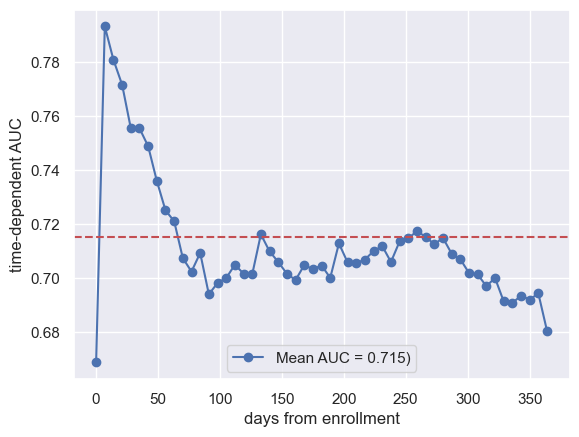

In [18]:
pipeline.fit(X_train, y_train)
cph_auc, cph_mean_auc,times = calc_dyn_auc(pipeline,X_test,y_test,y_train)
plot_auc(cph_auc,cph_mean_auc,times)

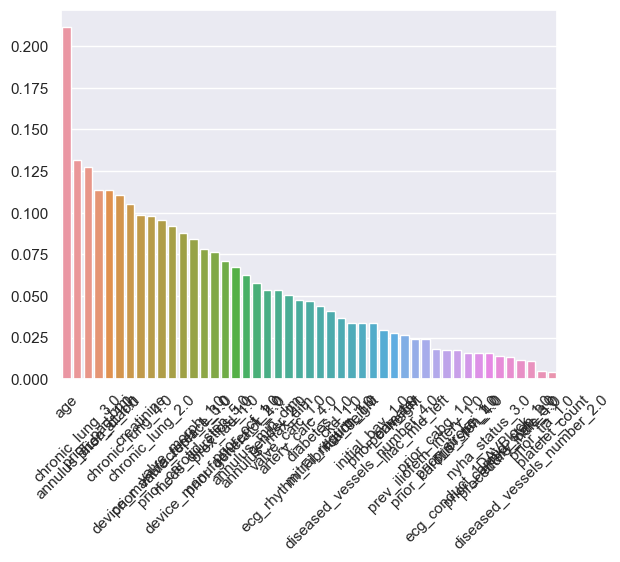

In [106]:
plot_cph_coef(pipeline.named_steps['model'].estimator_,feature_names = pipeline.feature_names_in_)

C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\metrics\_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\pipeline.py", line 1004, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_sur

C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sksurv\linear_model\coxph.py:173: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])
C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\metrics\_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\pipeline.py", line 1004, in 

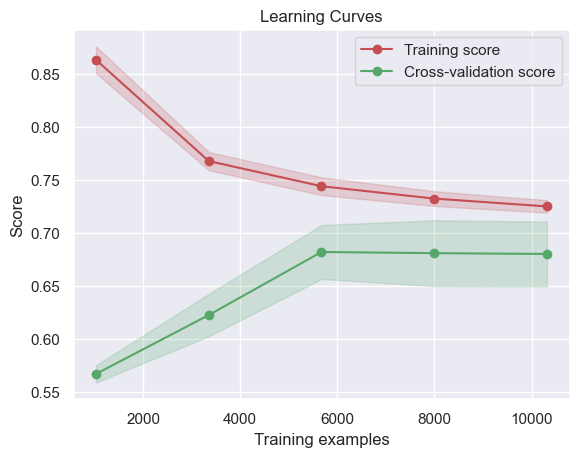

In [206]:
plot_learning_curve(pipeline, X_train, y_train, cv=5)

### lasso

In [207]:
# estimate the list of alphas that would decrease the number of features
coxnet =  CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01, max_iter=1000)

lasso_pipeline = Pipeline(
        [('scaler', StandardScaler()),
         #('dim_reduce', KernelPCA(n_components = 20,kernel='rbf')),
         ('model',  as_cumulative_dynamic_auc_scorer(CoxnetSurvivalAnalysis(l1_ratio=1.0, max_iter=1000, alpha_min_ratio=0.01), times=times))]
    )
lasso_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 as_cumulative_dynamic_auc_scorer(estimator=CoxnetSurvivalAnalysis(alpha_min_ratio=0.01,
                                                                                   l1_ratio=1.0,
                                                                                   max_iter=1000),
                                                  times=array([1.0000000e-05, 7.0000100e+00, 1.4000010e+01, 2.1000010e+01,
       2.8000010e+01, 3.5000010e+01, 4.2000010e+01, 4.9000010e+01,
       5.6000010e+01, 6.3000010e+01, 7.0000010e+01, 7.7000010e+01,
       8...
       1.9600001e+02, 2.0300001e+02, 2.1000001e+02, 2.1700001e+02,
       2.2400001e+02, 2.3100001e+02, 2.3800001e+02, 2.4500001e+02,
       2.5200001e+02, 2.5900001e+02, 2.6600001e+02, 2.7300001e+02,
       2.8000001e+02, 2.8700001e+02, 2.9400001e+02, 3.0100001e+02,
       3.0800001e+02, 3.1500001e+02, 3.2200001e+02, 3.2900001e+02,
       3.3600001e+02, 3.4300001e+02, 3.5000001e+02, 3.5700001e+02,
       3.6400001e+02])))])

In [14]:
estimated_alphas = lasso_pipeline.named_steps['model'].estimator_.alphas_
cv = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
cv_param_grid =  {"model__estimator__alphas": [[v] for v in estimated_alphas]}

times = np.arange(1e-5, 365, 7)

NameError: name 'lasso_pipeline' is not defined

In [209]:
pipeline = Pipeline(
        [('scaler', StandardScaler()),
         #('dim_reduce', KernelPCA(n_components = 20,kernel='rbf')),
         ('model',  as_cumulative_dynamic_auc_scorer(CoxnetSurvivalAnalysis(l1_ratio=1.0, max_iter=1000), times=times))]
    )

gcv_cindex = GridSearchCV(
    pipeline,
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=4,
).fit(X_train, y_train)

C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-

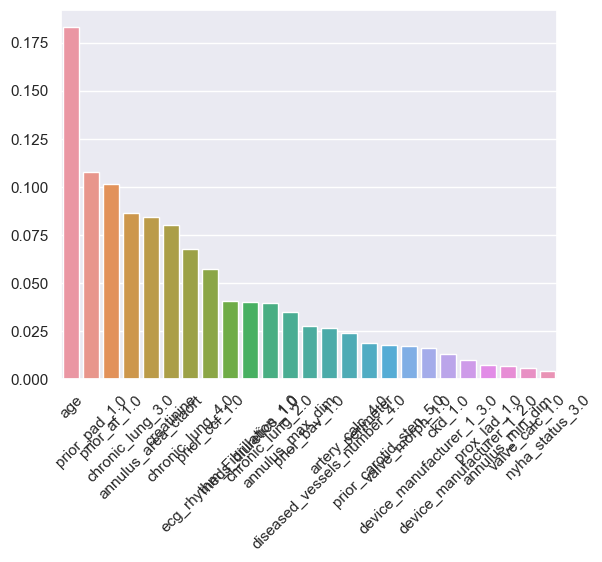

In [119]:
plot_cph_coef(gcv_cindex.best_estimator_.named_steps['model'].estimator_,feature_names = gcv_cindex.best_estimator_.feature_names_in_)

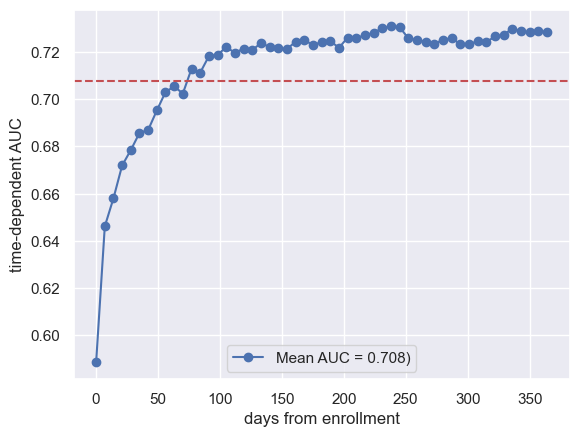

In [212]:
cph = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas = gcv_cindex.best_estimator_.named_steps['model'].estimator_.alphas, max_iter=1000,fit_baseline_model =True)
lasso_pipeline_final = Pipeline(
        [('scaler', StandardScaler()),
         #('dim_reduce', KernelPCA(n_components = 20,kernel='rbf')),
         ('model',  cph)]
    )


lasso_pipeline_final.fit(X_train, y_train)
cph_auc, cph_mean_auc,times = calc_dyn_auc(lasso_pipeline_final,X_train,y_train,y_train)
plot_auc(cph_auc,cph_mean_auc,times)

C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\metrics\_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\pipeline.py", line 1004, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_sur

C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sksurv\metrics.py:778: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=1000).
  self.estimator_ = self.estimator.fit(X, y, **fit_params)
C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sksurv\metrics.py:778: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=1000).
  self.estimator_ = self.estimator.fit(X, y, **fit_params)
C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
4 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits fai

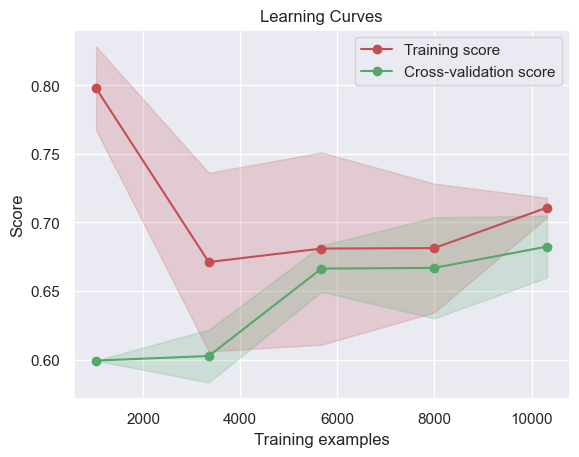

In [211]:
plot_learning_curve(lasso_pipeline_final, X_train, y_train, cv=5)

## Decision Tree

In [180]:
from sksurv.tree import SurvivalTree
cv_param_grid = {
     "model__estimator__max_depth": [5,6,7],
    "model__estimator__max_features": [None,'sqrt'],
    "model__estimator__min_samples_split": [0.001,0.002,0.004,0.01,0.015],
    "model__estimator__min_samples_leaf": [0.06,0.08,0.1,0.12,0.14]
}
cv = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
times = np.arange(1e-5, 365, 7)


pipeline = Pipeline(
        [('scaler', StandardScaler()),
         #('dim_reduce', PCA(n_components = 20)),
         ('model',  as_cumulative_dynamic_auc_scorer(
             SurvivalTree(random_state=random_state), 
             times=times))]
    )

gcv_iauc_dt = GridSearchCV(
    pipeline,
    param_grid=cv_param_grid,
    cv=cv,
    verbose=10,
    n_jobs=4,
    return_train_score=True
).fit(X_train, y_train)


Fitting 5 folds for each of 150 candidates, totalling 750 fits


In [181]:
print(gcv_iauc_dt.best_params_)
gcv_iauc_dt.best_score_

{'model__estimator__max_depth': 5, 'model__estimator__max_features': None, 'model__estimator__min_samples_leaf': 0.1, 'model__estimator__min_samples_split': 0.001}


0.624884388311717

In [182]:
tree = gcv_iauc_dt.best_estimator_.named_steps['model'].estimator.tree_

# Number of samples in each node
n_node_samples = tree.n_node_samples

# Print the number of samples in each node
for i in range(tree.node_count):
    print(f"Node {i} has {n_node_samples[i]} samples.")

Node 0 has 12898 samples.
Node 1 has 1802 samples.
Node 2 has 11096 samples.
Node 3 has 8407 samples.
Node 4 has 2106 samples.
Node 5 has 6301 samples.
Node 6 has 2079 samples.
Node 7 has 4222 samples.
Node 8 has 1973 samples.
Node 9 has 2249 samples.
Node 10 has 2689 samples.
Node 11 has 1291 samples.
Node 12 has 1398 samples.


C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\metrics\_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\pipeline.py", line 1004, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_sur

C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\metrics\_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\pipeline.py", line 1004, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_sur

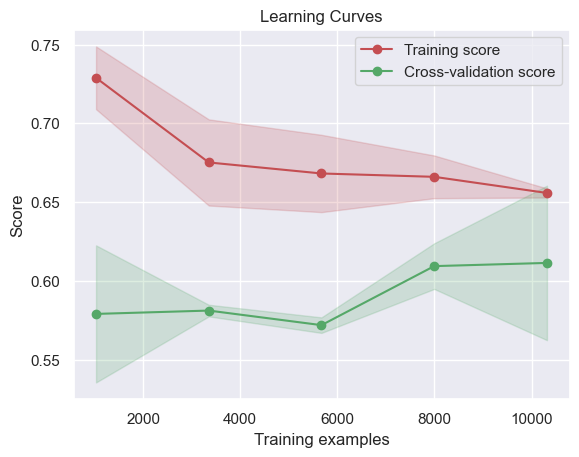

In [183]:
plot_learning_curve(gcv_iauc_dt.best_estimator_, X_train, y_train, cv=5)

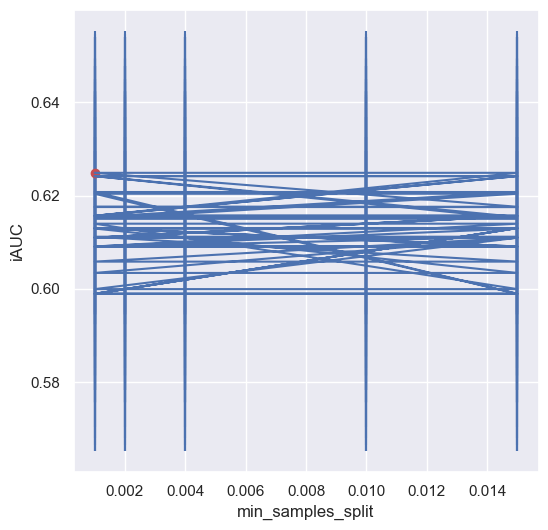

In [184]:
_, axs = plt.subplots(1, 1, figsize=(6, 6), sharex=True)
axs.set_xlabel("min_samples_split")
plot_grid_search_results(gcv_iauc_dt, axs, "iAUC","min_samples_split")

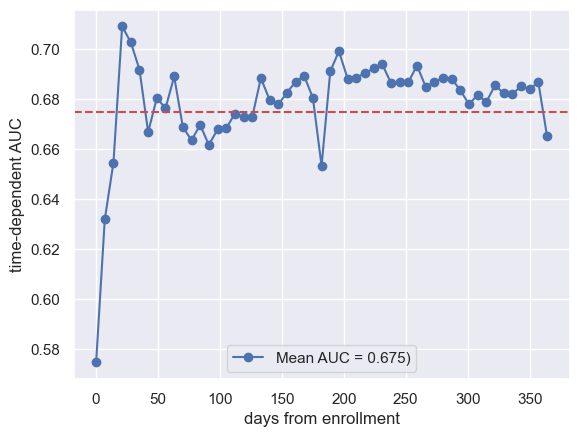

In [185]:
cph_auc, cph_mean_auc,times = calc_dyn_auc(gcv_iauc_dt.best_estimator_,X_test,y_test,y_train)
plot_auc(cph_auc,cph_mean_auc,times)

In [187]:
with open("model/dt_07262024.pkl", "wb") as f:
    dump(gcv_iauc_dt, f, protocol=5)

In [188]:
from sklearn.inspection import permutation_importance

result = permutation_importance(gcv_iauc_dt.best_estimator_, 
                                X_train, y_train, n_repeats=5, random_state=random_state,n_jobs=4)

In [191]:
dt_feature_importance = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_train.columns,
).sort_values(by="importances_mean", ascending=False)

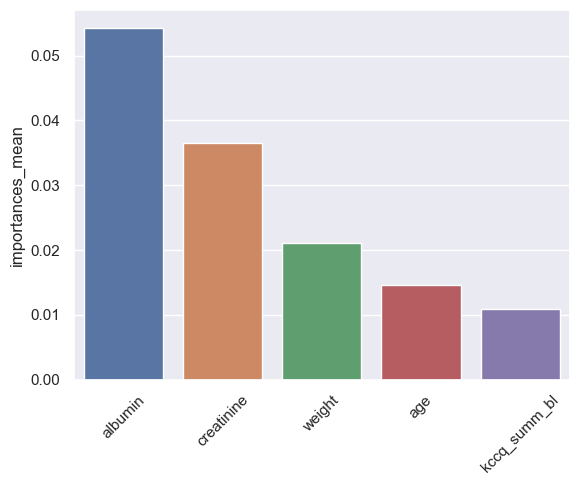

In [195]:
ax = sns.barplot(x=dt_feature_importance.index[dt_feature_importance['importances_mean']>0], 
                 y=dt_feature_importance.loc[dt_feature_importance['importances_mean']>0,'importances_mean'])
temp = plt.setp(ax.get_xticklabels(), rotation=45)

## RFS

for 5e-3
{'model__estimator__max_depth': 9,
 'model__estimator__max_features': 'sqrt',
 'model__estimator__min_samples_leaf': 10,
 'model__estimator__min_samples_split': 50,
 'model__estimator__n_estimators': 300}

In [20]:
rf_feature_importance = pd.read_csv("results/rf_feature_importance.csv",index_col=0)
non_zero_rf_fi = rf_feature_importance.query('importances_mean > 5e-3')

cv = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
times = np.arange(1e-5, 365, 7)
cv_param_grid = {
    "model__estimator__max_depth": [7,8,9], #8
    "model__estimator__max_features": ['sqrt'],
    "model__estimator__min_samples_split": [5,10,20,50],
    "model__estimator__min_samples_leaf": [5,10],
    "model__estimator__n_estimators": [280,300,320], #300
    #"model__estimator__bootstrap": [True]
}

rsf_pipeline = Pipeline(
        [('scaler', StandardScaler()),
         #('dim_reduce', PCA(n_components = 20)),
         ('model',  as_cumulative_dynamic_auc_scorer(
             RandomSurvivalForest(random_state=random_state), 
             times=times))]
    )

rsf_gcv_iauc = GridSearchCV(
    rsf_pipeline,
    param_grid=cv_param_grid,
    cv=cv,
    verbose=10,
    n_jobs=4,
    return_train_score=True
).fit(X_train.loc[:,non_zero_rf_fi.index], y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


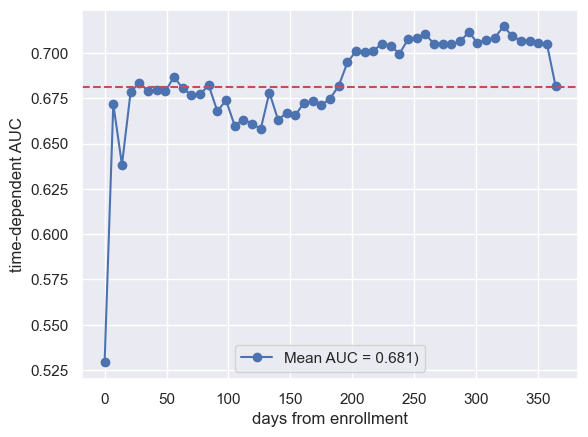

In [21]:




#rsf_pipeline.fit(X_train, y_train)
cph_auc, cph_mean_auc,times = calc_dyn_auc(rsf_gcv_iauc.best_estimator_,X_test.loc[:,non_zero_rf_fi.index],y_test,y_train)
plot_auc(cph_auc,cph_mean_auc,times)

#with open("model/rf.pkl", "wb") as f:
#    dump(rsf, f, protocol=5)

C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\metrics\_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\pipeline.py", line 1004, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_sur

C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\metrics\_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\pipeline.py", line 1004, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_sur

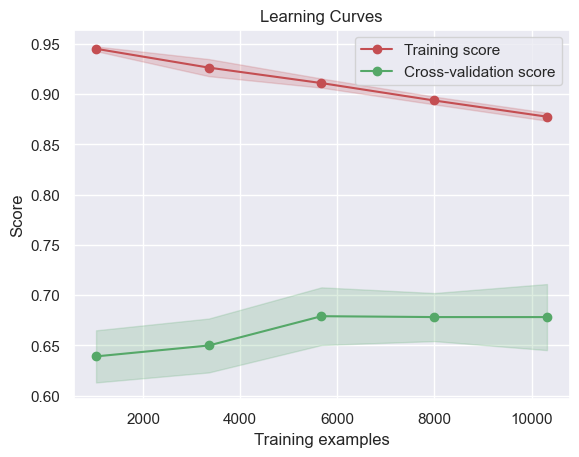

In [22]:
plot_learning_curve(rsf_gcv_iauc.best_estimator_, X_train.loc[:,non_zero_rf_fi.index], y_train, cv=5)

In [23]:
print(rsf_gcv_iauc.best_score_)
rsf_gcv_iauc.best_params_

0.6896440659296499


{'model__estimator__max_depth': 9,
 'model__estimator__max_features': 'sqrt',
 'model__estimator__min_samples_leaf': 10,
 'model__estimator__min_samples_split': 50,
 'model__estimator__n_estimators': 300}

In [24]:
pd.DataFrame(rsf_gcv_iauc.cv_results_).sort_values('mean_test_score',ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__estimator__max_depth,param_model__estimator__max_features,param_model__estimator__min_samples_leaf,param_model__estimator__min_samples_split,param_model__estimator__n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
70,65.289618,0.282058,3.122554,0.575835,9,sqrt,10,50,300,"{'model__estimator__max_depth': 9, 'model__est...",...,0.689644,0.023733,1,0.886429,0.881809,0.873368,0.872970,0.867896,0.876495,0.006679
57,64.080400,0.651163,2.840110,0.307747,9,sqrt,5,50,280,"{'model__estimator__max_depth': 9, 'model__est...",...,0.689643,0.026694,2,0.876941,0.875338,0.864863,0.863482,0.857369,0.867599,0.007433
69,60.482808,0.580856,2.924814,0.543764,9,sqrt,10,50,280,"{'model__estimator__max_depth': 9, 'model__est...",...,0.689585,0.023495,3,0.886205,0.881901,0.872626,0.873371,0.868033,0.876427,0.006631
58,68.333318,0.957666,3.048144,0.514559,9,sqrt,5,50,300,"{'model__estimator__max_depth': 9, 'model__est...",...,0.689502,0.026412,4,0.877396,0.874685,0.864036,0.863391,0.858098,0.867521,0.007305
59,73.274131,0.740519,3.065409,0.390995,9,sqrt,5,50,320,"{'model__estimator__max_depth': 9, 'model__est...",...,0.689477,0.025121,5,0.877570,0.875276,0.864712,0.863539,0.859153,0.868050,0.007120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,61.706246,0.540666,3.281735,0.325991,9,sqrt,5,5,300,"{'model__estimator__max_depth': 9, 'model__est...",...,0.683983,0.025427,67,0.920479,0.920202,0.904950,0.906282,0.903992,0.911181,0.007515
48,57.747714,0.468706,3.221374,0.558841,9,sqrt,5,5,280,"{'model__estimator__max_depth': 9, 'model__est...",...,0.683946,0.024113,69,0.919656,0.920545,0.905140,0.907374,0.902856,0.911114,0.007481
51,57.643049,0.567273,3.046736,0.334677,9,sqrt,5,10,280,"{'model__estimator__max_depth': 9, 'model__est...",...,0.683946,0.024113,69,0.919656,0.920545,0.905140,0.907374,0.902856,0.911114,0.007481
53,74.327393,0.381036,3.120639,0.257069,9,sqrt,5,10,320,"{'model__estimator__max_depth': 9, 'model__est...",...,0.683874,0.024801,71,0.920285,0.920957,0.905271,0.906609,0.904367,0.911498,0.007486


In [74]:
with open("model/rf_07292024_feature.pkl", "wb") as f:
    dump(rsf_gcv_iauc, f, protocol=5)

In [43]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf_gcv_iauc.best_estimator_, 
                                X_train, y_train, n_repeats=5, random_state=random_state,n_jobs=4)

In [45]:
rf_feature_importance = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=rsf_gcv_iauc.feature_names_in_,
).sort_values(by="importances_mean", ascending=False)

rf_feature_importance.to_csv("results/rf_feature_importance.csv")


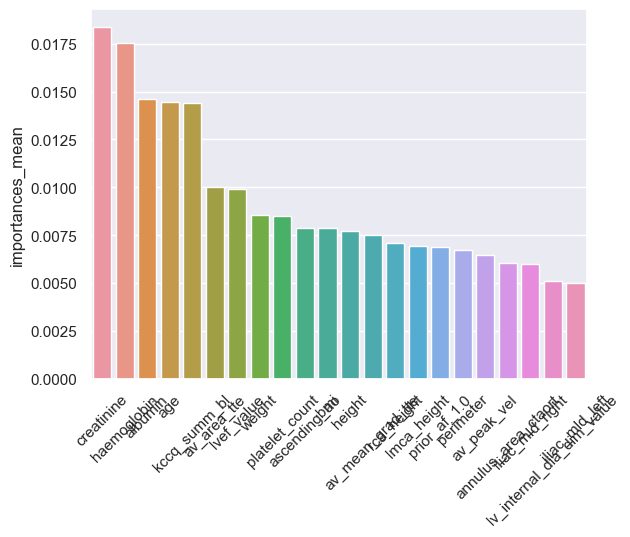

In [25]:
non_zero_rf_fi = rf_feature_importance.query('importances_mean > 5e-3')
ax = sns.barplot(non_zero_rf_fi, y = 'importances_mean',x=non_zero_rf_fi.index)
temp = plt.setp(ax.get_xticklabels(), rotation=45)

In [ ]:
for ele in rsf_pipeline.named_steps['model'].estimator_.estimators_:
    print(ele.tree_.max_depth)


## gradient boosting

In [141]:

cv_param_grid = {
    "model__estimator__n_estimators": [50,100,150],
     "model__estimator__max_depth": [1,2,3],
    "model__estimator__learning_rate": [0.8,0.9,1.0],
    "model__estimator__subsample": [0.8,0.9,1.0],
    "model__estimator__max_features": ['sqrt',None],
}

pipeline = Pipeline(
        [('scaler', StandardScaler()),
         #('dim_reduce', KernelPCA(n_components = 20,kernel='rbf')),
         ('model',  as_cumulative_dynamic_auc_scorer(
             GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=random_state), 
             times=times))]
    )

gcv_iauc = GridSearchCV(
    pipeline,
    param_grid=cv_param_grid,
    cv=cv,
    verbose=10,
    n_jobs=4,
    return_train_score=True
).fit(X_train, y_train)




#est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=random_state)
#est_cph_tree.fit(X_train_scale, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


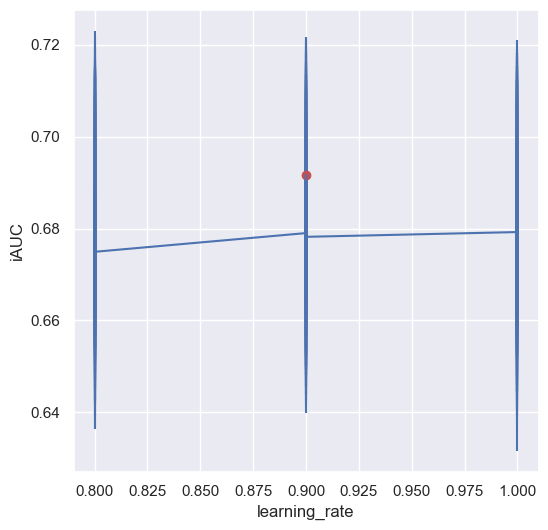

In [145]:
_, axs = plt.subplots(1, 1, figsize=(6, 6), sharex=True)
axs.set_xlabel("learning_rate")
plot_grid_search_results(gcv_iauc, axs, "iAUC","learning_rate")

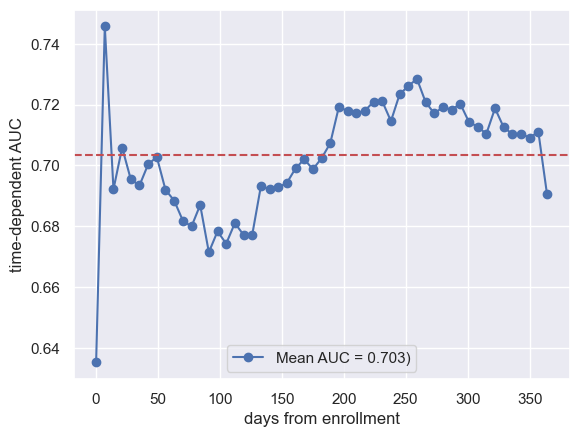

In [143]:
cph_auc, cph_mean_auc,times = calc_dyn_auc(gcv_iauc.best_estimator_,X_test,y_test,y_train)
plot_auc(cph_auc,cph_mean_auc,times)

In [151]:
with open("model/gb_07232024.pkl", "wb") as f:
    dump(gcv_iauc, f, protocol=5)

C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\metrics\_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\pipeline.py", line 1004, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_sur

C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\metrics\_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\pipeline.py", line 1004, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_sur

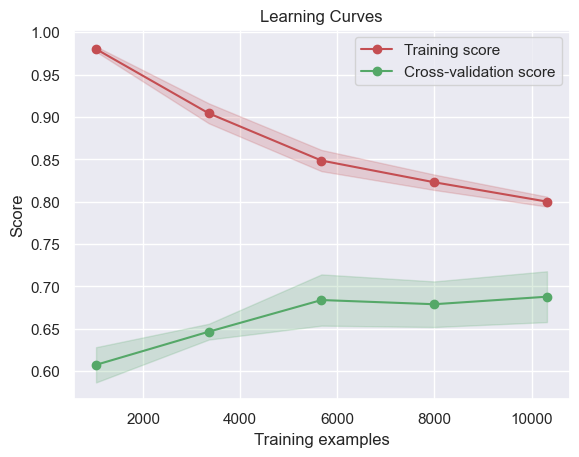

In [213]:
plot_learning_curve(gcv_iauc.best_estimator_, X_train, y_train, cv=5)

In [106]:
gb_pipeline = Pipeline(
        [('scaler', StandardScaler()),
         #('dim_reduce', KernelPCA(n_components = 20,kernel='rbf')),
         ('model',  as_cumulative_dynamic_auc_scorer(
             GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=2, 
                                              random_state=random_state,
                                              n_estimators=350,
                                             max_features='sqrt',
                                             subsample = 1.0), 
             times=times))]
    )

In [107]:
gb_fi_df = pd.read_csv('results/gb_feature_importance.csv',index_col=0)
gb_features = gb_fi_df.query('feature_importance > 0')['feature']

In [108]:
gb_pipeline.fit(X_train.loc[:,gb_features], y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 as_cumulative_dynamic_auc_scorer(estimator=GradientBoostingSurvivalAnalysis(learning_rate=1.0,
                                                                                             max_depth=2,
                                                                                             max_features='sqrt',
                                                                                             n_estimators=350,
                                                                                             random_state=108),
                                                  times=array([1.0000000e-05, 7.0000100e+00, 1.4000010e+01, 2.1000010e+01,
       2.8000010e+01, 3.5000010e+01, 4.2000010e+01, 4.9000010e+01,
       5.6000010e+...
       1.9600001e+02, 2.0300001e+02, 2.1000001e+02, 2.1700001e+02,
       2.2400001e+02, 2.3100001e+02, 2.3800001e+02, 2.4500001e+02,
       2.5200001e+02, 2.5900001e+02, 2.6600001e+02, 2.7300001e+02,
       2.8000001e+02, 2.8700001e+02, 2.9400001e+02, 3.0100001e+02,
       3.0800001e+02, 3.1500001e+02, 3.2200001e+02, 3.2900001e+02,
       3.3600001e+02, 3.4300001e+02, 3.5000001e+02, 3.5700001e+02,
       3.6400001e+02])))])

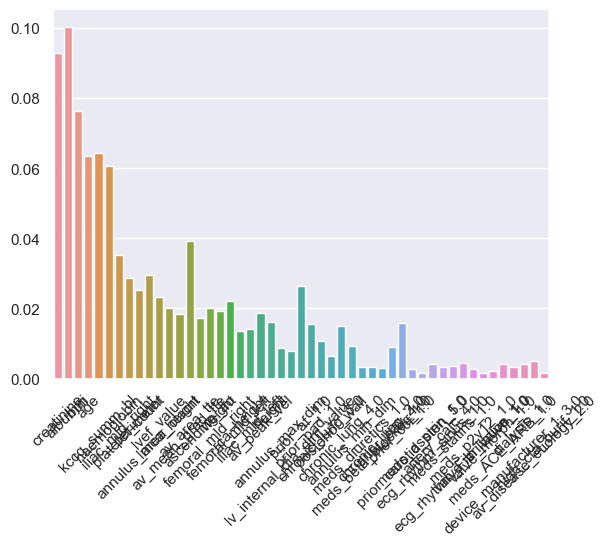

In [109]:
gb_feature_importances = gb_pipeline.named_steps['model'].estimator_.feature_importances_
ax = sns.barplot(x=gb_pipeline.feature_names_in_[gb_feature_importances>1e-3], 
                 y=gb_feature_importances[gb_feature_importances>1e-3])
temp = plt.setp(ax.get_xticklabels(), rotation=45)

In [103]:
gb_fi_df = pd.DataFrame({
    'feature': gb_pipeline.feature_names_in_,
    'feature_importance': gb_feature_importances
}).sort_values('feature_importance',ascending=False)
gb_fi_df.to_csv('results/gb_feature_importance.csv')

C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\metrics\_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\pipeline.py", line 1004, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_sur

C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\metrics\_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\sklearn\pipeline.py", line 1004, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\harri\anaconda3\envs\tavi_sur

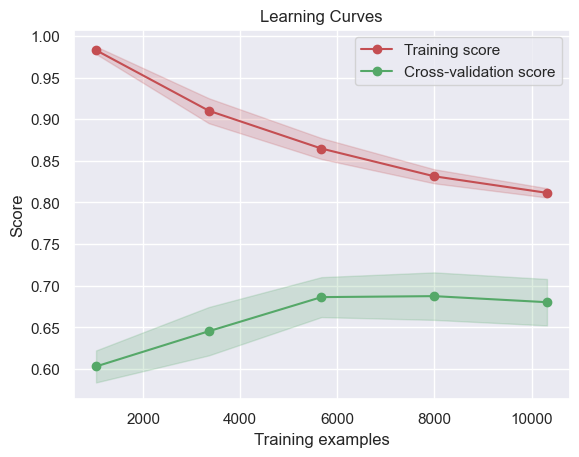

In [110]:
plot_learning_curve(gb_pipeline, X_train, y_train, cv=5)

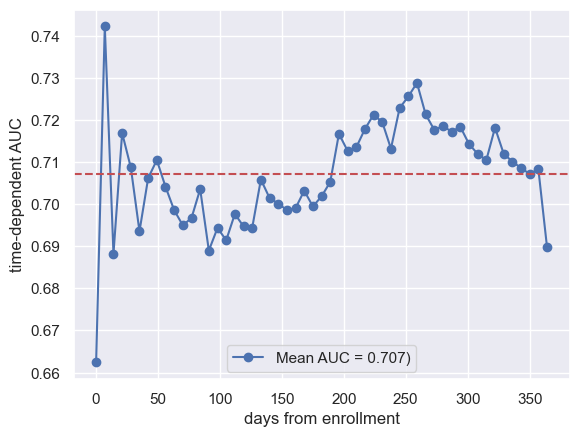

In [111]:
## more complex model for n_estimators = 300
cph_auc, cph_mean_auc,times = calc_dyn_auc(gb_pipeline,X_test.loc[:,gb_features],y_test,y_train)
plot_auc(cph_auc,cph_mean_auc,times)

## SVM

In [52]:
from sksurv.svm import FastSurvivalSVM

cv = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
times = np.arange(1e-5, 365, 7)


lsvm_pipeline = Pipeline(
        [('scaler', StandardScaler()),
         #('dim_reduce', PCA(n_components = 20)),
         ('model',  as_concordance_index_ipcw_scorer(
             FastSurvivalSVM(random_state=random_state,
                             alpha=0.01,
                             rank_ratio =1.0
                            ), tau=times[-1]))]
    )

lsvm_pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 as_concordance_index_ipcw_scorer(estimator=FastSurvivalSVM(alpha=0.01,
                                                                            optimizer='avltree',
                                                                            random_state=108),
                                                  tau=364.00001))])

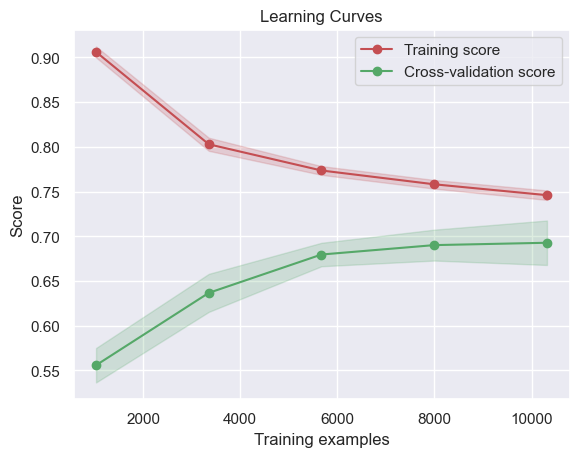

In [53]:
plot_learning_curve(lsvm_pipeline, X_train, y_train, cv=5)

In [54]:
lsvm_pipeline.score(X_test,y_test)

0.6868391918033809

In [28]:
cph_auc, cph_mean_auc,times = calc_dyn_auc(lsvm_pipeline,X_test,y_test,y_train)
plot_auc(cph_auc,cph_mean_auc,times)

AttributeError: This 'Pipeline' has no attribute 'predict_cumulative_hazard_function'